In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from yass.augment import make
from pathlib import Path

import yass
from yass.neuralnetwork import NeuralNetDetector
from yass import set_config, read_config

In [2]:
yass.set_config("../../config/49-lab.yaml")
CONFIG = read_config()

In [10]:
path_to_ground_truth = str(Path('~/data/groundtruth_ej49_data1_set1.mat').expanduser())

kk = io.loadmat(path_to_ground_truth)

# L_gt has length total number of spikes; it is the cluster index for each spike
# spt_gt has length total number of spikes; it is the time for each spike
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt'] + 10
spike_train = np.concatenate((spt_gt, L_gt),axis=1)

min_amp = 5
max_amp = 80


path_to_data = str(Path('~/data/tmp/preprocess/standarized.bin').expanduser())

chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13,
                    14, 15, 16, 17, 18, 19, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                    36, 37, 38, 39, 41, 42, 43, 44, 45, 46,
                    47, 48]

# TODO: update, no longer is ptp but amplitude
(x_clean, ptp,
 noise) = make.testing_data(CONFIG, spike_train, chosen_templates,
                               min_amp, max_amp, path_to_data,
                               20)

100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


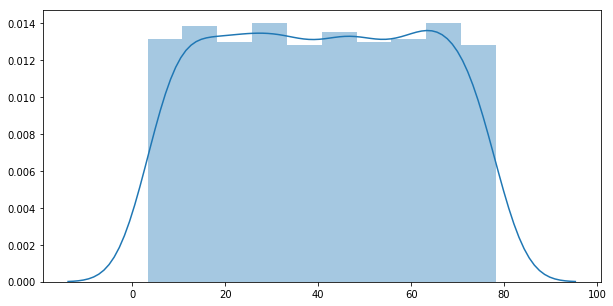

In [11]:
import seaborn as sns
sns.distplot(ptp)

In [12]:
import pandas as pd
new_ptp = pd.qcut(ptp, 20)
new_ptp

[(7.288, 10.845], (7.288, 10.845], (10.845, 14.114], (14.114, 18.111], (18.111, 21.878], ..., (59.503, 63.636], (63.636, 66.602], (66.602, 70.572], (70.572, 74.392], (74.392, 78.234]]
Length: 780
Categories (20, interval[float64]): [(3.29, 7.288] < (7.288, 10.845] < (10.845, 14.114] < (14.114, 18.111] ... (63.636, 66.602] < (66.602, 70.572] < (70.572, 74.392] < (74.392, 78.234]]

In [13]:
mid_point = int((x_clean.shape[1]-1)/2)
R = CONFIG.spike_size
R = 10
MID_POINT_IDX = slice(mid_point - R, mid_point + R + 1)

In [14]:
import pandas as pd

def process_group(g_id, g, model):
    wfs = np.stack(g.waveforms.values, axis=0)
    preds = model.predict(wfs[:, MID_POINT_IDX, :])
    return g_id, preds.mean()

def compute_proportions(x_clean, ptp, model):
    # convert to data frame
    wfs = [x for x in x_clean]
    df = pd.DataFrame(data={"waveforms": wfs,
                            "ptp": pd.qcut(ptp, 20, labels=False)})
    
    # sort by peak-to-peak
    df.sort_values(by='ptp', inplace=True)
    
    # group and compute proportion of correct predictions
    vals = [process_group(g_id, g, model) for g_id, g in df.groupby('ptp')]
    
    ptps, props = list(zip(*vals))
    
    return ptps, props

In [15]:
paths = ['/home/Edu/shengao-models/detect_nn_min3max15_noise2.ckpt',
         '/home/Edu/dev/private-yass/nnet/models/detect-11-Jul-2018@21-00-57.ckpt']

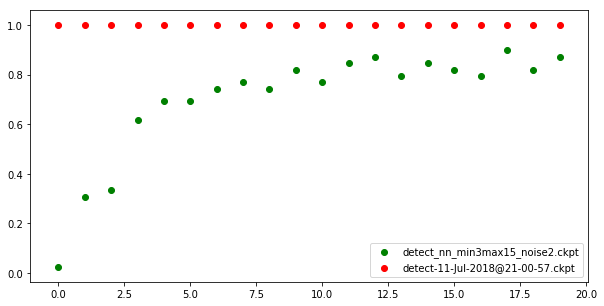

In [16]:
plt.rcParams['figure.figsize'] = (10, 5)

colors = ['g', 'r', 'b', 'k']

for i, path_to_model in enumerate(paths):
    model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index)
    ptps, props = compute_proportions(x_clean, ptp, model)
    plt.scatter(ptps, props, color=colors[i],
                label=path_to_model.split('/')[-1])

plt.legend()